# Read in the data

In [15]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [16]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [17]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [18]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [19]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [20]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [21]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [22]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [23]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [24]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

# Bar Chart of Correlation from Survey

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
#correlations.bar()

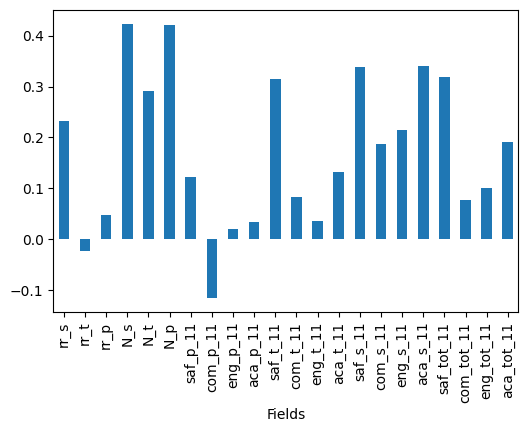

In [27]:
correlations[survey_fields].plot.bar()
plt.xlabel("Fields")
plt.show()

# Scatter plot of Safety measures with Sat scores

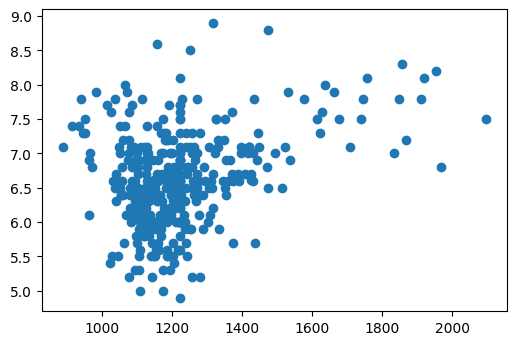

In [28]:
plt.scatter(combined["sat_score"], combined["saf_s_11"])
plt.show()

In [29]:
combined_less_than_1400 = combined[combined["sat_score"]<1400]

In [30]:
combined_more_than_1400 = combined[combined["sat_score"]>1400]

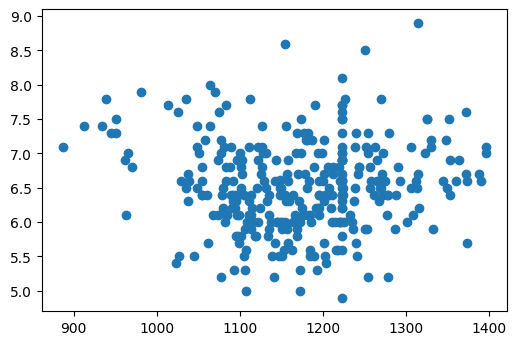

In [31]:
plt.scatter(combined_less_than_1400["sat_score"], combined_less_than_1400["saf_s_11"])
plt.show()

### The safety scores correlate positively with sat scores when scores are ranging above 1400. For lower sat scores, safety scores are less correlated

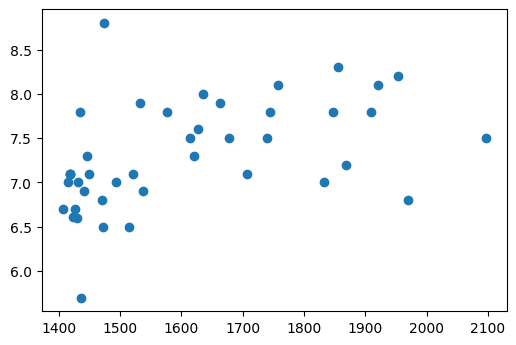

In [32]:
plt.scatter(combined_more_than_1400["sat_score"], combined_more_than_1400["saf_s_11"])
plt.show()

# Calculate average safety score for each borough

In [33]:
combined["borough"] = combined["DBN"].str[2:3]

In [34]:
combined_by_borough = combined.groupby("borough")
mean_by_borough = combined_by_borough.agg(numpy.mean)
print(mean_by_borough[["saf_s_11", "sat_score"]])
print(mean_by_borough[["saf_t_11", "sat_score"]])

         saf_s_11    sat_score
borough                       
K        6.370755  1181.364461
M        6.831370  1278.331410
Q        6.721875  1286.753032
R        6.530000  1382.500000
X        6.606577  1157.598203
         saf_t_11    sat_score
borough                       
K        6.985849  1181.364461
M        7.287778  1278.331410
Q        7.365625  1286.753032
R        7.210000  1382.500000
X        7.026882  1157.598203


### Lower safety areas have lower average sat scores, but sat scores do not change between medium safe areas and very safe areas

In [35]:
combined["borough"].head()

0    M
1    M
2    M
3    M
4    M
Name: borough, dtype: object

In [36]:
combined["DBN"].value_counts(dropna=False)

04M610    2
05M367    1
27Q309    1
03M860    1
31R047    1
         ..
08X293    1
27Q400    1
02M520    1
02M425    1
19K409    1
Name: DBN, Length: 362, dtype: int64

In [37]:
#Racial columns
rac_cols = ["white_per", "asian_per", "black_per", "hispanic_per"]

In [38]:
correlation_sat_score = combined.corr()["sat_score"]

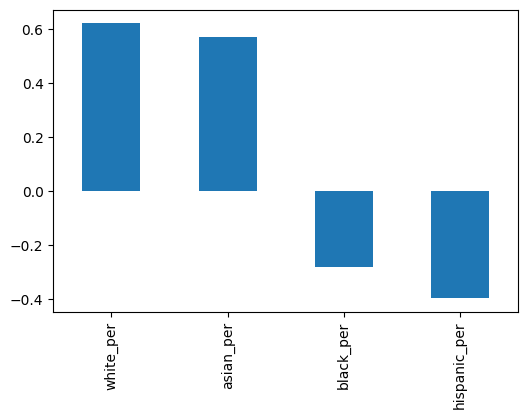

In [39]:
correlation_sat_score[rac_cols].plot.bar()

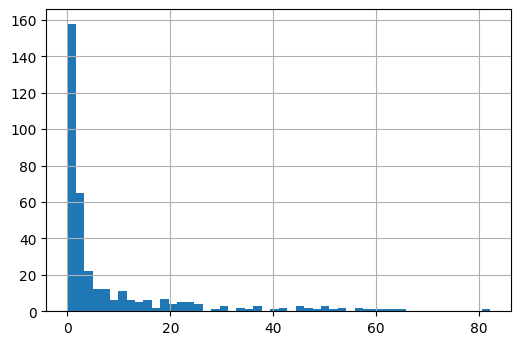

In [40]:
#combined["white_per"].value_counts(dropna=False).sort_values(ascending=False).head(10)
combined["white_per"].hist(bins=50)

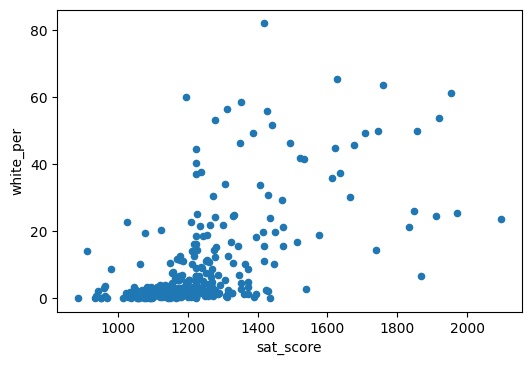

In [41]:
combined.plot.scatter("sat_score", "white_per")

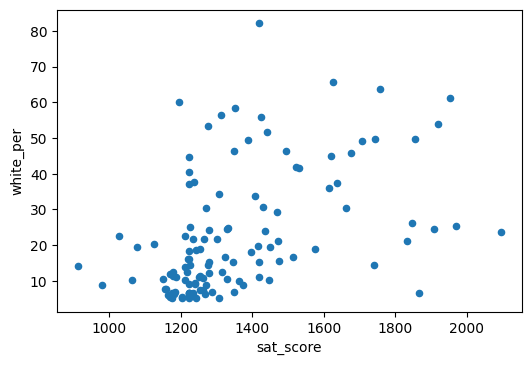

In [42]:
combined_high_white_per = combined[combined["white_per"]>5]
combined_high_white_per.plot.scatter("sat_score", "white_per")

In [43]:
print(combined_high_white_per.corr()["sat_score"]["white_per"])

0.4601402165235676


In [44]:
combined_low_white_per = combined[combined["white_per"]<5]
print(combined_low_white_per.corr()["sat_score"]["white_per"])

0.2970860172792017


## Safety score relationship with sat score

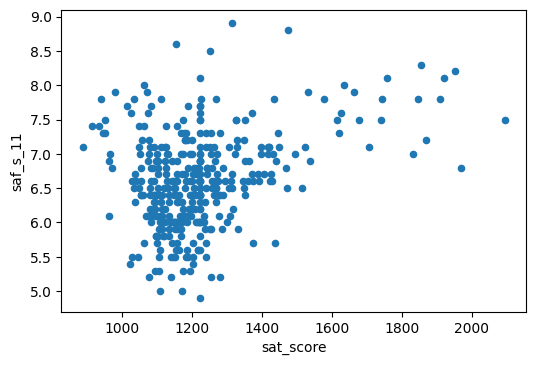

In [46]:
combined.plot.scatter("sat_score", "saf_s_11")

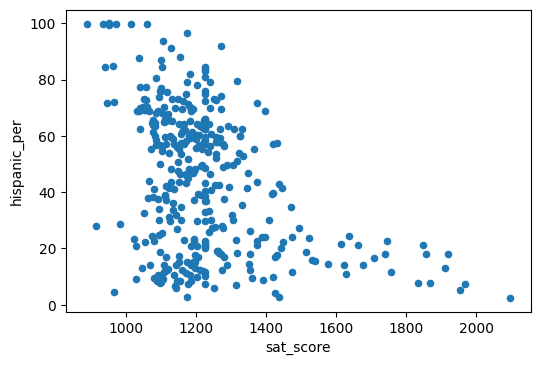

In [47]:
combined.plot.scatter("sat_score", "hispanic_per")

In [51]:
#combined["hispanic_per"].value_counts(dropna=False)
combined_lowsat_highhispanic = combined[(combined["sat_score"] < 1400) & (combined["hispanic_per"] > 80)]

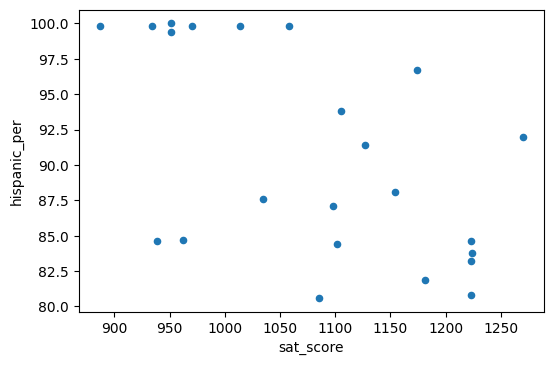

In [52]:
combined_lowsat_highhispanic.plot.scatter("sat_score", "hispanic_per")

In [53]:
combined_lowsat_highhispanic.corr().loc["sat_score","hispanic_per"]

-0.5531375452985916

In [54]:
combined.corr().loc["sat_score","hispanic_per"]

-0.39698493078147196

In [56]:
combined_highhispanic = combined[combined["hispanic_per"]>95]
combined_highhispanic.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist,borough
44,02M542,MANHATTAN BRIDGES HIGH SCHOOL,66,336.0,378.0,344.0,1058.0,Manhattan Bridges High School,67.000000,102.000000,...,0,0,0.0,0.0,0.0,"525 West 50Th Street\nNew York, NY 10019\n(40....",40.765027,-73.992517,02,M
82,06M348,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,70,380.0,395.0,399.0,1174.0,0,129.028846,197.038462,...,0,0,0.0,0.0,0.0,"511 West 182Nd Street\nNew York, NY 10033\n(40...",40.848879,-73.930807,06,M
89,06M552,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,56,339.0,349.0,326.0,1014.0,GREGORIO LUPERON HS SCI & MATH,88.000000,138.000000,...,0,0,0.0,0.0,0.0,"501 West 165Th\nNew York, NY 10032\n(40.838032...",40.838032,-73.938371,06,M
125,09X365,ACADEMY FOR LANGUAGE AND TECHNOLOGY,54,315.0,339.0,297.0,951.0,Academy for Language and Technology,20.000000,20.000000,...,0,0,0.0,0.0,0.0,"1700 Macombs Road\nBronx, NY 10453\n(40.849102...",40.849102,-73.916088,09,X
141,10X342,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,49,300.0,333.0,301.0,934.0,International School for Liberal Arts,55.000000,73.000000,...,0,0,0.0,0.0,0.0,"2780 Reservoir Avenue\nBronx, NY 10468\n(40.87...",40.870377,-73.898163,10,X


In [57]:
combined_lowhispanic = combined[combined["hispanic_per"]<10]
combined_lowhispanic.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist,borough
37,02M475,STUYVESANT HIGH SCHOOL,832,679.0,735.0,682.0,2096.0,STUYVESANT HS,1510.0,2819.0,...,0,0,0.0,0.0,0.0,"345 Chambers Street\nNew York, NY 10282\n(40.7...",40.717746,-74.014049,02,M
46,02M545,HIGH SCHOOL FOR DUAL LANGUAGE AND ASIAN STUDIES,78,412.0,581.0,431.0,1424.0,High School for Dual Language and Asian Studies,61.0,96.0,...,0,0,0.0,0.0,0.0,"350 Grand Street\nNew York, NY 10002\n(40.7168...",40.716867,-73.989532,02,M
151,10X445,BRONX HIGH SCHOOL OF SCIENCE,731,632.0,688.0,649.0,1969.0,BRONX HS OF SCIENCE,1190.0,2435.0,...,0,0,0.0,0.0,0.0,"75 West 205 Street\nBronx, NY 10468\n(40.87705...",40.877056,-73.889780,10,X
187,13K430,BROOKLYN TECHNICAL HIGH SCHOOL,1277,587.0,659.0,587.0,1833.0,BROOKLYN TECHNICAL HS,2117.0,3692.0,...,0,0,0.0,0.0,0.0,"29 Ft Greene Place\nBrooklyn, NY 11217\n(40.68...",40.688107,-73.976745,13,K
192,13K595,BEDFORD ACADEMY HIGH SCHOOL,89,438.0,443.0,431.0,1312.0,Bedford Academy High School,43.0,57.0,...,0,0,0.0,0.0,0.0,"1119 Bedford Avenue\nBrooklyn, NY 11216\n(40.6...",40.685381,-73.954268,13,K


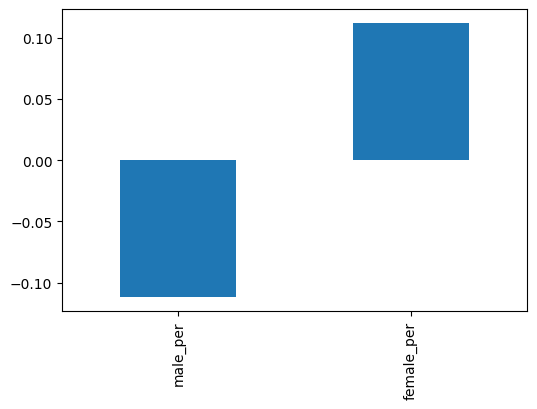

In [62]:
combined.corr().loc["sat_score",["male_per", "female_per"]].plot.bar()

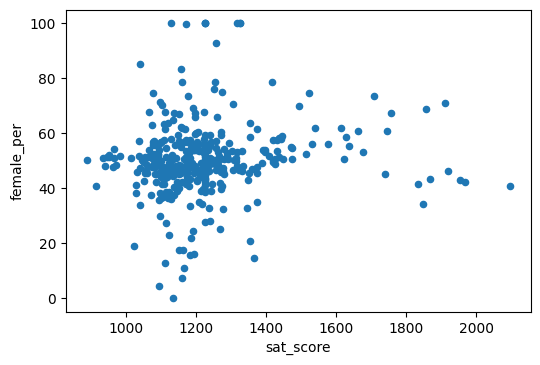

In [63]:
combined.plot.scatter("sat_score","female_per")

In [64]:
combined_highsat_highfemale = combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]

In [65]:
combined_highsat_highfemale.head(10)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist,borough
5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624.0,604.0,628.0,1856.0,0,129.028846,197.038462,...,0,0,0.0,0.0,0.0,"525 East Houston Street\nNew York, NY 10002\n(...",40.718962,-73.976066,01,M
26,02M416,ELEANOR ROOSEVELT HIGH SCHOOL,127,572.0,594.0,592.0,1758.0,Eleanor Roosevelt High School,155.000000,235.000000,...,0,0,0.0,0.0,0.0,"411 East 76 Street\nNew York, NY 10021\n(40.77...",40.770116,-73.953379,02,M
60,03M479,BEACON HIGH SCHOOL,261,577.0,575.0,592.0,1744.0,BEACON SCHOOL,166.000000,197.000000,...,0,0,0.0,0.0,0.0,"227-243 West 61St Street\nNew York, NY 10023\n...",40.772158,-73.987797,03,M
61,03M485,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,531,566.0,564.0,577.0,1707.0,FIORELLO H.LAGUARDIA HS,691.000000,1236.000000,...,0,0,0.0,0.0,0.0,"100 Amsterdam Avenue\nNew York, NY 10023\n(40....",40.773671,-73.985269,03,M
302,25Q525,TOWNSEND HARRIS HIGH SCHOOL,278,621.0,651.0,638.0,1910.0,TOWNSEND HARRIS HS,613.000000,796.000000,...,0,0,0.0,0.0,0.0,"149-11 Melbourne Avenue\nFlushing, NY 11367\n(...",40.734408,-73.821417,25,Q


In [70]:
print (combined.corr().loc["sat_score","AP_Per"])

0.057170813907669614


In [69]:
combined["AP_Per"] = (combined["AP Test Takers "]/combined["total_enrollment"])*100

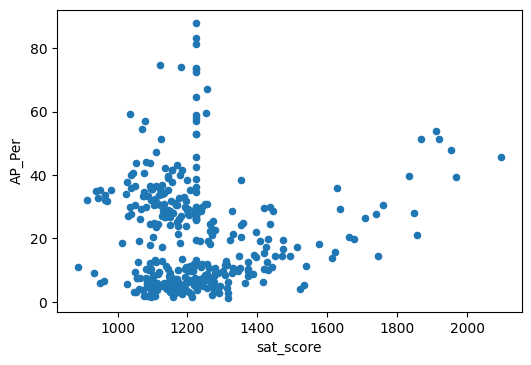

In [71]:
combined.plot.scatter("sat_score", "AP_Per")

In [73]:
print(combined[combined["sat_score"]>1500].corr().loc["sat_score","AP_Per"])

0.8198006899923105
